## Random Forest importance

Random forests is one the most popular machine learning algorithms. It is so successful because it provide good predictive performance, low overfitting and easy interpretability. This interpretability is given by the fact that it is straightforward to derive the importance of each variable on the tree decision. In other words, it is easy to compute how much each variable is contributing to the decision.

Random forests consist typically of 4-12 hundred decision trees, each of them built over a random extraction of the observations from the dataset and a random extraction of the features. Not every tree sees all the features or all the observations, and this guarantees that the trees are de-correlated and therefore less prone to over-fitting. Each tree is also a sequence of yes-no questions based on a single or a combination of features. At each node (that is, at each question), the three divides the dataset in 2 buckets, each of them hosting observations that are more similar among themselves and different from the ones in the other bucket. Therefore, the importance of each feature is derived by how "pure" each of the buckets is. 

For classification, the measure of impurity is either Gini or the entropy. For regression the  measure of impurity is the variance. When training a tree, it is possible to compute how much each feature decreases the impurity. The more a feature decreases the impurity, the more important the feature is. In random forests, the impurity decrease elicited by each feature is averaged across trees to determine the final importance of the variable.

In general, features that are selected at the top of the trees are more important than features that are selected at the end nodes of the trees, as generally the top splits lead to bigger information gains.

**Note**
- Random Forests and decision trees in general give preference to features with high cardinality
- Correlated features will be given equal or similar importance, but overall reduced importance compared to the same tree built without correlated counterparts.

I will demonstrate how to select features based on tree importance using a regression and classification dataset.

In [ ]:
# %load_ext autoreload
# %autoreload 2

In [1]:
print (sys.path)

['c:\\Users\\Arindam Banerji\\CopyFolder\\IoT_thoughts\\python-projects\\kaggle_experiments\\feature-engineering\\recipes\\notebooks\\feat_eng_select', 'C:\\Users\\Arindam Banerji\\CopyFolder\\IOT_thoughts\\python-projects\\kaggle_experiments\\feature-engineering\\recipes\\helper_src', 'c:\\Python310\\python310.zip', 'c:\\Python310\\DLLs', 'c:\\Python310\\lib', 'c:\\Python310', '', 'c:\\Python310\\lib\\site-packages', 'c:\\Python310\\lib\\site-packages\\win32', 'c:\\Python310\\lib\\site-packages\\win32\\lib', 'c:\\Python310\\lib\\site-packages\\Pythonwin']


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

from helper_fe_v2 import (
            get_full_datapath_nm,
            read_df_from_file,
            check_module_members,
            gen_correlation,
            do_bkwd_fwd_selection,
            yaml_path,
            read_yaml_conf,
            remove_duplicates, 
            drop_const_features,
            drop_quasi_const_features ,
            run_randomForestClassifier,
            run_logistic,
            run_randomForestRegressor
)

## Classification

In [3]:
config = read_yaml_conf(yaml_path())
print ("yaml_ conf ", config ) 

yaml_ conf  {'write_file': True, 'base_dir': 'C:\\Users\\Arindam Banerji\\CopyFolder\\IOT_thoughts\\python-projects\\kaggle_experiments', 'full_config_file': 'C:\\Users\\Arindam Banerji\\CopyFolder\\IOT_thoughts\\python-projects\\kaggle_experiments\\feature-engineering\\recipes\\py-projects.yaml', 'current_proj_dir': 'C:\\Users\\Arindam Banerji\\CopyFolder\\IOT_thoughts\\python-projects\\kaggle_experiments\\feature-engineering\\recipes', 'data_dir_nm': 'input_data\raw', 'files': {'test_data_set2': 'fselect_dataset_2.csv', 'housing_data': 'housing_prices_train.csv', 'test_data_set1': 'fselect_dataset_1.csv', 'titanic_data': 'fe-cookbook-titanic.csv', 'comp_eda_file': 'none.csv'}, 'project_parms': {'use_mlxtnd': 'False'}, 'process_eda': {'main_file': 'fselect_dataset_2.csv', 'compre_file': 'none.csv', 'pairwise_analysis': 'on', 'show_html': 'False'}, 'RandomForestConfig': {'n_estimators': 200, 'rand_state': 39, 'max_depth': 4}}


In [5]:
data = read_df_from_file ( config['files']['test_data_set2'], set_nrows=False, nrws=0 ) 
data.shape

Full path NM exists  C:\Users\Arindam Banerji\CopyFolder\IOT_thoughts\python-projects\kaggle_experiments\feature-engineering\recipes\input_data\raw\fselect_dataset_2.csv
full_path nm -from read_df C:\Users\Arindam Banerji\CopyFolder\IOT_thoughts\python-projects\kaggle_experiments\feature-engineering\recipes\input_data\raw\fselect_dataset_2.csv


(50000, 109)

In [6]:
data.head() 

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,...,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109
0,4.532710,3.280834,17.982476,4.404259,2.349910,0.603264,2.784655,0.323146,12.009691,0.139346,...,2.079066,6.748819,2.941445,18.360496,17.726613,7.774031,1.473441,1.973832,0.976806,2.541417
1,5.821374,12.098722,13.309151,4.125599,1.045386,1.832035,1.833494,0.709090,8.652883,0.102757,...,2.479789,7.795290,3.557890,17.383378,15.193423,8.263673,1.878108,0.567939,1.018818,1.416433
2,1.938776,7.952752,0.972671,3.459267,1.935782,0.621463,2.338139,0.344948,9.937850,11.691283,...,1.861487,6.130886,3.401064,15.850471,14.620599,6.849776,1.098210,1.959183,1.575493,1.857893
3,6.020690,9.900544,17.869637,4.366715,1.973693,2.026012,2.853025,0.674847,11.816859,0.011151,...,1.340944,7.240058,2.417235,15.194609,13.553772,7.229971,0.835158,2.234482,0.946170,2.700606
4,3.909506,10.576516,0.934191,3.419572,1.871438,3.340811,1.868282,0.439865,13.585620,1.153366,...,2.738095,6.565509,4.341414,15.893832,11.929787,6.954033,1.853364,0.511027,2.599562,0.811364


In [7]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 108), (15000, 108))

In [8]:
# we fit Random Forests and select features in 2 lines of code

# first I specify the Random Forest instance and its parameters

# Then I use the selectFromModel class from sklearn
# to automatically select the features

# SelectFrom model will select those features which importance
# is greater than the mean importance of all the features
# by default, but you can alter this threshold if you want to

sel_ = SelectFromModel(RandomForestClassifier(n_estimators=10, random_state=10))

sel_.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=10,
                                                 random_state=10))

In [9]:
# this command let's me visualise those features that were selected.

# sklearn will select those features which importance values
# are greater than the mean of all the coefficients.

sel_.get_support()

array([ True,  True, False, False, False,  True, False, False,  True,
       False, False, False,  True, False,  True,  True,  True, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False,  True, False, False, False,
       False, False,  True, False,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False,  True,  True, False, False, False,
       False, False, False,  True,  True, False, False,  True, False,
       False, False,  True, False, False, False, False,  True, False])

In [10]:
# let's make a list and count the selected features

selected_feat = X_train.columns[(sel_.get_support())]

len(selected_feat)

27

In [11]:
selected_feat

Index(['var_1', 'var_2', 'var_6', 'var_9', 'var_13', 'var_15', 'var_16',
       'var_17', 'var_20', 'var_21', 'var_30', 'var_34', 'var_37', 'var_55',
       'var_60', 'var_67', 'var_69', 'var_70', 'var_71', 'var_82', 'var_87',
       'var_88', 'var_95', 'var_96', 'var_99', 'var_103', 'var_108'],
      dtype='object')

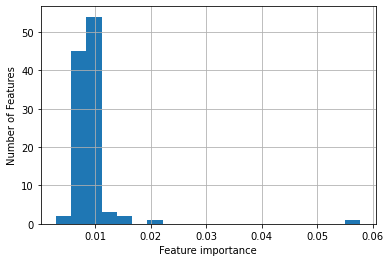

In [12]:
# and now let's plot the distribution of importances

pd.Series(sel_.estimator_.feature_importances_.ravel()).hist(bins=20)
plt.xlabel('Feature importance')
plt.ylabel('Number of Features')
plt.show()

In [13]:
# and now, let's compare the  amount of selected features
# with the amount of features which importance is above the
# mean of all features, to make sure we understand the output of
# SelectFromModel

print('total features: {}'.format((X_train.shape[1])))

print('selected features: {}'.format(len(selected_feat)))

print(
    'features with importance greater than the mean importance of all features: {}'.format(
        np.sum(sel_.estimator_.feature_importances_ >
               sel_.estimator_.feature_importances_.mean())))

total features: 108
selected features: 27
features with importance greater than the mean importance of all features: 27


A few things to note:

- If we change the parameters of the tree, we may obtain different features
- How many features to select is somewhat arbitrary

With SelectFromModel we use the mean of all importances as threshold. We can modify this threshold within the SelectFromModel if we want more or less features.

## Regression

In [14]:
data = read_df_from_file ( config['files']['housing_data'], set_nrows=False, nrws=0 ) 
data.shape

Full path NM exists  C:\Users\Arindam Banerji\CopyFolder\IOT_thoughts\python-projects\kaggle_experiments\feature-engineering\recipes\input_data\raw\housing_prices_train.csv
full_path nm -from read_df C:\Users\Arindam Banerji\CopyFolder\IOT_thoughts\python-projects\kaggle_experiments\feature-engineering\recipes\input_data\raw\housing_prices_train.csv


(1460, 81)

In [15]:
# In practice, feature selection should be done after data pre-processing,
# so ideally, all the categorical variables are encoded into numbers,
# and then you can assess how deterministic they are of the target

# here for simplicity I will use only numerical variables
# select numerical columns:

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

(1460, 38)

In [16]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((1022, 37), (438, 37))

In [17]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [18]:
# we train a random forest for regression and select features
# in 2 lines of code

# SelectFrom model will select those features which importance
# is greater than the mean importance of all the features
# by default, but you can alter this threshold if you want to

sel_ = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=10))
sel_.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestRegressor(random_state=10))

In [19]:
# let's make a list and count the selected features
selected_feat = X_train.columns[(sel_.get_support())]
len(selected_feat)

5

In [20]:
# and now, let's compare the  amount of selected features
# with the amount of features which importance is above the
# mean importance, to make sure we understand the output of
# sklearn

print('total features: {}'.format((X_train.shape[1])))

print('selected features: {}'.format(len(selected_feat)))

print(
    'features with coefficients greater than the mean coefficient: {}'.format(
        np.sum(sel_.estimator_.feature_importances_ >
               sel_.estimator_.feature_importances_.mean())))

total features: 37
selected features: 5
features with coefficients greater than the mean coefficient: 5


Selecting features by using tree derived feature importance is a very straightforward, fast and generally accurate way of selecting good features for machine learning. In particular, if you are going to build tree methods.

However, as I said, correlated features will show in a tree similar importance, but lower than compared to what their importance would be if the tree was built without the correlated counterparts.

In situations like this, it is better to select features recursively, rather than altogether like we are doing in this lecture.

That is all for this lecture, I hope you enjoyed it and see you in the next one!

## Recursive Feature Selection using Random Forests importance

Random Forests assign equal or similar importance to features that are highly correlated. In addition, when features are correlated, the importance assigned is lower than the importance attributed to the feature itself, should the tree be built without the correlated counterparts.

Therefore, instead of eliminating features based on importance by brute force like we did in the previous notebook, we could get a better selection by removing one feature at a time, and recalculating the importance on each round. This procedure is called Recursive Feature Elimination (RFE)

RFE is a hybrid between embedded and wrapper methods: it is based on computation derived when fitting the model, but it also requires fitting several models.

The cycle is as follows:

- Build Random Forests using all features
- Remove least important feature
- Build Random Forests and recalculate importance
- Repeat until a criteria is met

In this situation, when a feature that is highly correlated to another one is removed, then, the importance of the remaining feature increases. This may lead to a better feature space selection. On the downside, building several Random Forests is quite time and compute resource consuming, in particular if the dataset contains a high number of features.

I will demonstrate how to select features based Random Forests importance recursively using sklearn on a classification dataset.

In [21]:
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score

In [22]:
config = read_yaml_conf(yaml_path())
data = read_df_from_file ( config['files']['test_data_set2'], set_nrows=False, nrws=0 ) 
data.shape

Full path NM exists  C:\Users\Arindam Banerji\CopyFolder\IOT_thoughts\python-projects\kaggle_experiments\feature-engineering\recipes\input_data\raw\fselect_dataset_2.csv
full_path nm -from read_df C:\Users\Arindam Banerji\CopyFolder\IOT_thoughts\python-projects\kaggle_experiments\feature-engineering\recipes\input_data\raw\fselect_dataset_2.csv


(50000, 109)

In [23]:
data.head()

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,...,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109
0,4.532710,3.280834,17.982476,4.404259,2.349910,0.603264,2.784655,0.323146,12.009691,0.139346,...,2.079066,6.748819,2.941445,18.360496,17.726613,7.774031,1.473441,1.973832,0.976806,2.541417
1,5.821374,12.098722,13.309151,4.125599,1.045386,1.832035,1.833494,0.709090,8.652883,0.102757,...,2.479789,7.795290,3.557890,17.383378,15.193423,8.263673,1.878108,0.567939,1.018818,1.416433
2,1.938776,7.952752,0.972671,3.459267,1.935782,0.621463,2.338139,0.344948,9.937850,11.691283,...,1.861487,6.130886,3.401064,15.850471,14.620599,6.849776,1.098210,1.959183,1.575493,1.857893
3,6.020690,9.900544,17.869637,4.366715,1.973693,2.026012,2.853025,0.674847,11.816859,0.011151,...,1.340944,7.240058,2.417235,15.194609,13.553772,7.229971,0.835158,2.234482,0.946170,2.700606
4,3.909506,10.576516,0.934191,3.419572,1.871438,3.340811,1.868282,0.439865,13.585620,1.153366,...,2.738095,6.565509,4.341414,15.893832,11.929787,6.954033,1.853364,0.511027,2.599562,0.811364


In [24]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 108), (15000, 108))

In [25]:
# we do model training and feature selection in 2 lines of code

# first I specify the Random Forest and its parameters

# Then RFE from sklearn to remove features recursively

# RFE will remove one feature at each iteration => the least  important.
# then it will build another random forest and repeat
# till a criteria is met.

# in sklearn the criteria to stop is an arbitrary number
# of features to select, that we need to decide before hand
# not the best solution, but a solution

sel_ = RFE(RandomForestClassifier(n_estimators=10, random_state=10), n_features_to_select=27)
sel_.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(n_estimators=10, random_state=10),
    n_features_to_select=27)

In [26]:
# selected features

selected_feat = X_train.columns[(sel_.get_support())]
len(selected_feat)

27

In [27]:
# let's display the list of features
selected_feat

Index(['var_4', 'var_14', 'var_21', 'var_25', 'var_30', 'var_31', 'var_34',
       'var_38', 'var_41', 'var_46', 'var_53', 'var_55', 'var_56', 'var_70',
       'var_71', 'var_73', 'var_79', 'var_82', 'var_86', 'var_87', 'var_88',
       'var_90', 'var_92', 'var_93', 'var_96', 'var_104', 'var_108'],
      dtype='object')

In [28]:
# these are the features selected in the previous
# notebook where we used SelectFromModel from sklearn
# without doing it recursively

previous_lecture_selected_features = [
    'var_1', 'var_2', 'var_6', 'var_9', 'var_13', 'var_15', 'var_16', 'var_17',
    'var_20', 'var_21', 'var_30', 'var_34', 'var_37', 'var_55', 'var_60',
    'var_67', 'var_69', 'var_70', 'var_71', 'var_82', 'var_87', 'var_88',
    'var_95', 'var_96', 'var_99', 'var_103', 'var_108'
]

In [29]:
# features selected recursively
run_randomForestClassifier(X_train[selected_feat],
                  X_test[selected_feat],
                  y_train, y_test, yaml_path())

Train set
Random Forests roc-auc: 0.7046591498448564
Test set
Random Forests roc-auc: 0.6904472637540937


array([[0.37253398, 0.62746602],
       [0.21224039, 0.78775961],
       [0.19444672, 0.80555328],
       ...,
       [0.25807847, 0.74192153],
       [0.38462335, 0.61537665],
       [0.38994431, 0.61005569]])

In [30]:
# features selected altogether
run_randomForestClassifier(X_train[previous_lecture_selected_features],
                  X_test[previous_lecture_selected_features],
                  y_train, y_test, yaml_path())

Train set
Random Forests roc-auc: 0.7126509093226299
Test set
Random Forests roc-auc: 0.7009195513033531


array([[0.38095524, 0.61904476],
       [0.21765451, 0.78234549],
       [0.2208501 , 0.7791499 ],
       ...,
       [0.19208147, 0.80791853],
       [0.39994195, 0.60005805],
       [0.39428315, 0.60571685]])

We see that RFE did not return a better subset of features. The performance of the model built using the variables selected directly from the first RandomForest was enough to find a good subset of features.

In my opinion the RFE from sklearn does not bring forward a massive advantage respect to the SelectFromModel method and personally I tend to use the second to select my features.

That is all for this lecture, I hope you enjoyed it and see you in the next one!

## Feature selection with decision trees, review
### Putting it all together

In [31]:
from sklearn.feature_selection import VarianceThreshold

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score

In [32]:
config = read_yaml_conf(yaml_path())
data = read_df_from_file ( config['files']['test_data_set1'], set_nrows=False, nrws=0 ) 
data.shape

Full path NM exists  C:\Users\Arindam Banerji\CopyFolder\IOT_thoughts\python-projects\kaggle_experiments\feature-engineering\recipes\input_data\raw\fselect_dataset_1.csv
full_path nm -from read_df C:\Users\Arindam Banerji\CopyFolder\IOT_thoughts\python-projects\kaggle_experiments\feature-engineering\recipes\input_data\raw\fselect_dataset_1.csv


(50000, 301)

In [33]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 300), (15000, 300))

In [34]:
# I keep a copy of the dataset with all the variables
# to compare the performance of machine learning models
# at the end of the notebook

X_train_original = X_train.copy()
X_test_original = X_test.copy()

In [35]:
constant_features = drop_const_features(X_train, X_test, drop_feat='True')

(35000, 266) (15000, 266)


In [36]:
X_train, X_test, features_to_keep = drop_quasi_const_features(threshold=0.01,
                                                              X_train=X_train, 
                                                              X_test=X_test, 
                                                              drop_feat='True')

(35000, 215) (15000, 215)


In [37]:
duplicated_feat = remove_duplicates(X_train, X_test, drop_dup=True)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
(35000, 205) (15000, 205)


In [38]:
# I keep a copy of the dataset without constant, quasi-constant and duplicated variables
# to measure the performance of machine learning models
# at the end of the notebook

X_train_basic_filter = X_train.copy()
X_test_basic_filter = X_test.copy()

In [39]:
# remove correlated features to reduce the feature space
# remove correlated features to reduce the feature space

corr_features = gen_correlation(X_train, 0.8)
print('correlated features: ', len(set(corr_features)) )

correlated features:  93


In [40]:
# removed correlated  features
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((35000, 112), (15000, 112))

In [41]:
# keep a copy of the dataset at  this stage
X_train_corr = X_train.copy()
X_test_corr = X_test.copy()

In [42]:
# select features using the impotance derived from
# random forests

sel_ = SelectFromModel(RandomForestClassifier(n_estimators=50, random_state=10))
sel_.fit(X_train, y_train)

# remove features with zero coefficient from dataset
# and parse again as dataframe (output of sklearn is
# numpy array)
X_train_rf = pd.DataFrame(sel_.transform(X_train))
X_test_rf = pd.DataFrame(sel_.transform(X_test))

# add the columns name
X_train_rf.columns = X_train.columns[(sel_.get_support())]
X_test_rf.columns = X_train.columns[(sel_.get_support())]

In [43]:
X_train_rf.shape, X_test_rf.shape

((35000, 16), (15000, 16))

In [44]:
# original
run_randomForestClassifier(X_train_original,
                  X_test_original,
                  y_train, y_test, yaml_path())

Train set
Random Forests roc-auc: 0.807612232524249
Test set
Random Forests roc-auc: 0.7868832427636059


array([[0.9830392 , 0.0169608 ],
       [0.92255307, 0.07744693],
       [0.97249843, 0.02750157],
       ...,
       [0.98297334, 0.01702666],
       [0.98246554, 0.01753446],
       [0.9199013 , 0.0800987 ]])

In [45]:
# filter methods - basic
run_randomForestClassifier(X_train_basic_filter,
                  X_test_basic_filter,
                  y_train, y_test, yaml_path())

Train set
Random Forests roc-auc: 0.810290026780428
Test set
Random Forests roc-auc: 0.7914020645941601


array([[0.98450622, 0.01549378],
       [0.91940171, 0.08059829],
       [0.97123244, 0.02876756],
       ...,
       [0.98453254, 0.01546746],
       [0.98462966, 0.01537034],
       [0.91597684, 0.08402316]])

In [46]:
# filter methods - correlation
run_randomForestClassifier(X_train_corr,
                  X_test_corr,
                  y_train, y_test, yaml_path())

Train set
Random Forests roc-auc: 0.8066004772684517
Test set
Random Forests roc-auc: 0.7859521124929707


array([[0.98443145, 0.01556855],
       [0.92607865, 0.07392135],
       [0.96483524, 0.03516476],
       ...,
       [0.98441518, 0.01558482],
       [0.98346227, 0.01653773],
       [0.92007532, 0.07992468]])

In [47]:
# filter methods - univariate roc-auc
run_randomForestClassifier(X_train_corr,
                  X_test_corr,
                  y_train, y_test, yaml_path())

Train set
Random Forests roc-auc: 0.8066004772684517
Test set
Random Forests roc-auc: 0.7859521124929707


array([[0.98443145, 0.01556855],
       [0.92607865, 0.07392135],
       [0.96483524, 0.03516476],
       ...,
       [0.98441518, 0.01558482],
       [0.98346227, 0.01653773],
       [0.92007532, 0.07992468]])

In [48]:
# embedded methods - Random forests
run_randomForestClassifier(X_train_rf,
                  X_test_rf,
                  y_train, y_test, yaml_path())

Train set
Random Forests roc-auc: 0.825594244784318
Test set
Random Forests roc-auc: 0.8037861254524954


array([[0.99057627, 0.00942373],
       [0.94289959, 0.05710041],
       [0.95476487, 0.04523513],
       ...,
       [0.98991585, 0.01008415],
       [0.98888135, 0.01111865],
       [0.93272561, 0.06727439]])

We see that Random Forests built using 16 features display a slightly higher performance than a model built with all features!